In [1]:
import tkinter as tk
from tkinter import filedialog
import numpy as np  
import matplotlib.pyplot as plt
import cv2 
from scipy import ndimage
from skimage import filters ,color


In [2]:
def select_images():
    root = tk.Tk()
    root.wm_attributes('-topmost', 1)
    root.withdraw()

    file_paths = filedialog.askopenfilenames(title="Select Image Files", filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.gif;*.tif;")])
    if file_paths:
        image = cv2.imread(file_paths[0])
        image = cv2.resize(image, (640, 480))
    return image

In [3]:
def img_plot(img,title = 'img'):
    plt.figure(figsize=(8,6))
    plt.imshow((img), cmap=plt.cm.gray)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.title(title)  
    plt.show()

In [4]:
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_RBUTTONUP:
        cv2.destroyAllWindows()
def BGRtoHSV(BGR):
    hsv = cv2.cvtColor(BGR, cv2.COLOR_BGR2HSV)
    return cv2.split(hsv)
def HSVtoBGR(H,S,V):
    hsv = np.stack([H,S,V],axis=2)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

In [5]:
def denoise_tv(image, weight=1/90, eps=1.e-6, max_num_iter=200):
    """Perform total-variation denoising on n-dimensional images.
    
    Parameters
    ----------
    image : ndarray
        n-D input data to be denoised.
    weight : float, optional
        Denoising weight It is equal to 1/lambda . The greater `weight`, the more denoising (at
        the expense of fidelity to `input`).
        
    eps : float, optional
        Relative difference of the value of the cost function that determines
        the stop criterion. The algorithm stops when:

            (E_(n-1) - E_n) < eps * E_0
        where E_0 is the initial value of the cost function.    

    max_num_iter : int, optional
        Maximal number of iterations used for the optimization.

    Returns
    -------
    out : ndarray
        Denoised array of floats.

    Notes
    -----
    Rudin, Osher and Fatemi algorithm.
    """
    image = image.astype(np.float64)
    ndim = image.ndim
    p = np.zeros((image.ndim, ) + image.shape, dtype=image.dtype)
    g = np.zeros_like(p)
    d = np.zeros_like(image)
    i = 0
    while i < max_num_iter:
        if i > 0:
            # d will be the (negative) divergence of p
            d = -p.sum(0)
            slices_d = [slice(None), ] * ndim
            slices_p = [slice(None), ] * (ndim + 1)
            for ax in range(ndim):
                slices_d[ax] = slice(1, None)
                slices_p[ax+1] = slice(0, -1)
                slices_p[0] = ax
                d[tuple(slices_d)] += p[tuple(slices_p)]
                slices_d[ax] = slice(None)
                slices_p[ax+1] = slice(None)
            out = image + d
        else:
            out = image
        E = (d ** 2).sum()

        # g stores the gradients of out along each axis
        # e.g. g[0] is the first order finite difference along axis 0
        slices_g = [slice(None), ] * (ndim + 1)
        for ax in range(ndim):
            slices_g[ax+1] = slice(0, -1)
            slices_g[0] = ax
            g[tuple(slices_g)] = np.diff(out, axis=ax)
            slices_g[ax+1] = slice(None)

        norm = np.sqrt((g ** 2).sum(axis=0))[np.newaxis, ...]
        E += weight * norm.sum()
        tau = 1. / (2.*ndim)
        norm *= tau / weight
        norm += 1.
        p -= tau * g
        p /= norm
        E /= float(image.size)
        if i == 0:
            E_init = E
            E_previous = E
        else:
            if np.abs(E_previous - E) < eps * E_init:
                break
            else:
                E_previous = E
        i += 1
    print(i,tau)    
    return out.astype(np.uint8)

In [6]:
def adaptive_gamma_transform(img, n,m):
    """
    Applies adaptive gamma transform on a given image.

    Args:
        img: A grayscale image to be processed.
        m: Size of the local area (height).
        n: Size of the local area (width).

    Returns:
        A gamma corrected image.
    """
    img = (img+1.)/255.
    # Pad input image with zeros to handle edge cases
    rows, cols = img.shape
    gamma_corrected = np.zeros((rows, cols))
    padded_image = cv2.copyMakeBorder(img, n//2, n//2, m//2, m//2, cv2.BORDER_CONSTANT, value=0)

   
    for i in range(rows):
        for j in range(cols):
            local_area = padded_image[i:i+m, j:j+m]
            N = np.mean(local_area)
            b = np.var(local_area)

            # Calculate the gamma value.
            gamma = N/img[i,j] + b

            # Gamma correct the pixel value.
            gamma_corrected[i,j] = np.power(img[i,j], gamma)

    return (gamma_corrected*255).astype(np.uint8)

In [7]:
#MSR
def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)
    
    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian
    
    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)

def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales
    img = img + 1.0
    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)
    
    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)
    
    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    return cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

In [8]:
def tanh(img, sigma):

    return np.tanh(img/get_gaussian_blur(img, ksize=0, sigma=sigma))

def mtanh(img, sigma_scales=[15, 80, 250]):
    # Multi-scale tanh
    img = img + 1.0
    i_t = np.zeros(img.shape)
    # for each sigma scale compute tanh
    for sigma in sigma_scales:
        i_t += tanh(img, sigma)
    
    # divide tanh by weights of each scale
    # here we use equal weights
    i_t = i_t / len(sigma_scales)
    
    return (i_t*255).astype(np.uint8)

In [9]:
def DFIE(img , sigma=[10,40,300],n = 3,m= 3):
    i_l = msr(img,sigma).astype(np.float32) # calculate  weighted MSR
    i_t = mtanh(img,sigma).astype(np.float32) # calculate  weighted tanh
    
    # Using gausian to estimate mean , much faster
    i_l_mean = cv2.blur(i_l, (n, m))
    i_t_mean = cv2.blur(i_t, (n, m))
    a= i_t_mean/i_l_mean
    alpha = cv2.normalize(a, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    balanced = alpha*i_l + (1-alpha)*i_t

    # rows, cols = img.shape
    # balanced = np.zeros((rows, cols))
    # padded_i_l = cv2.copyMakeBorder(i_l, n//2, n//2, m//2, m//2, cv2.BORDER_CONSTANT, value=0)
    # padded_i_t = cv2.copyMakeBorder(i_t, n//2, n//2, m//2, m//2, cv2.BORDER_CONSTANT, value=0)
    # for i in range(rows):
    #     for j in range(cols):
    #         # Calculate the indices for the local area.
    #         local_i_l = padded_i_l[i:i+m, j:j+m]
    #         local_i_t = padded_i_t[i:i+m, j:j+m]
    #         alpha = np.mean(local_i_t)/np.mean(local_i_l)
    #         balanced[i,j] = alpha*i_l[i,j]+(1-alpha)*i_t[i,j]

    return balanced.astype(np.uint8)

In [10]:
def three_dim_gamma_correction(image, n, m, weights=[0.1,0.1,0.15]):
    # Initialize output image
    image = (image+1.)/255.
    output_image = np.zeros_like(image)
    
    # Pad input image with zeros to handle edge cases
    padded_image = cv2.copyMakeBorder(image, n//2, n//2, m//2, m//2, cv2.BORDER_CONSTANT, value=0)
    gx = cv2.Sobel(padded_image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(padded_image, cv2.CV_64F, 0, 1, ksize=3)
    Gr =np.hypot(gx,gy)
    # Iterate over each pixel in the input image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract local region of size n x m around the pixel
            local_region = padded_image[i:i+n, j:j+m]

            # Compute local maximum, mean gradient, and variance
            local_max = np.max(local_region)

            local_mean_gradient = np.mean(Gr[i:i+n, j:j+m])
            local_variance = np.var(local_region)

            # Compute gamma correction factor based on local statistics and weights
            gamma = weights[0]*np.exp(image[i,j]/local_max) + weights[1]*np.exp(local_mean_gradient) + weights[2]*np.exp(local_variance)

            # Apply gamma correction to pixel value
            output_image[i,j] = np.power(image[i,j],gamma)*255

    return output_image.astype(np.uint8)

In [151]:
Img =select_images()
h,s,v = BGRtoHSV(Img)

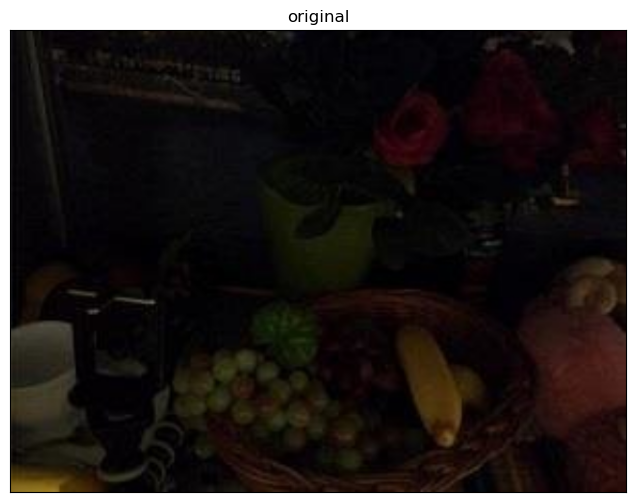

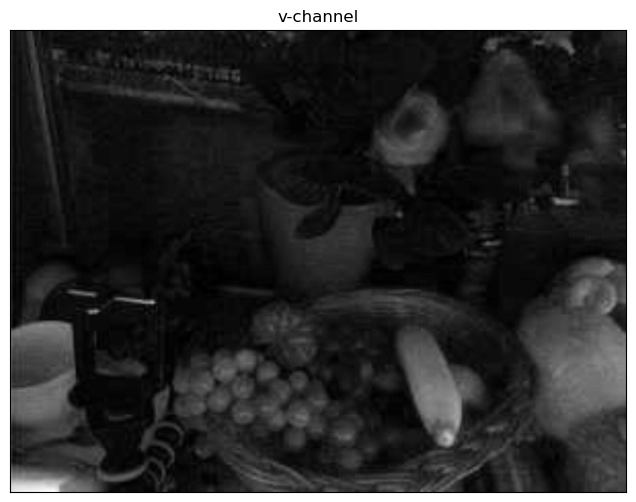

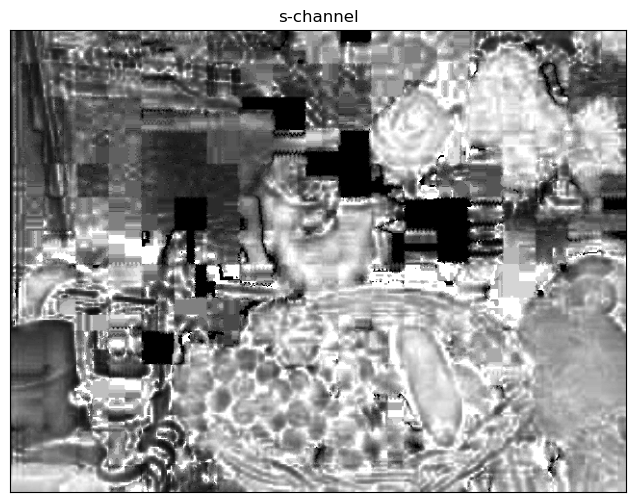

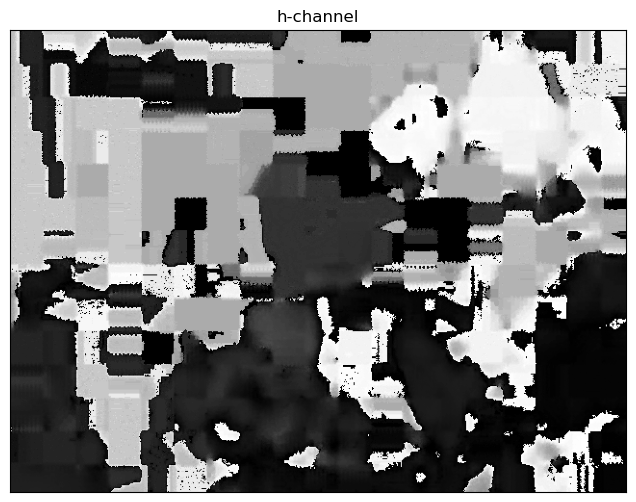

In [152]:
img_plot(np.stack([Img[:,:,2],Img[:,:,1],Img[:,:,0]],axis=2),'original')
img_plot(v,'v-channel')
img_plot(s,'s-channel')
img_plot(h,'h-channel')

In [131]:
cv2.imshow('f', v/255)
cv2.setMouseCallback('f', mouse_callback)  
cv2.waitKey(0)
cv2.destroyAllWindows()
print(h.min() ,h.max())
print(s.min() ,s.max())
print(v.min() ,v.max())

0 179
0 255
0 255


29 0.25


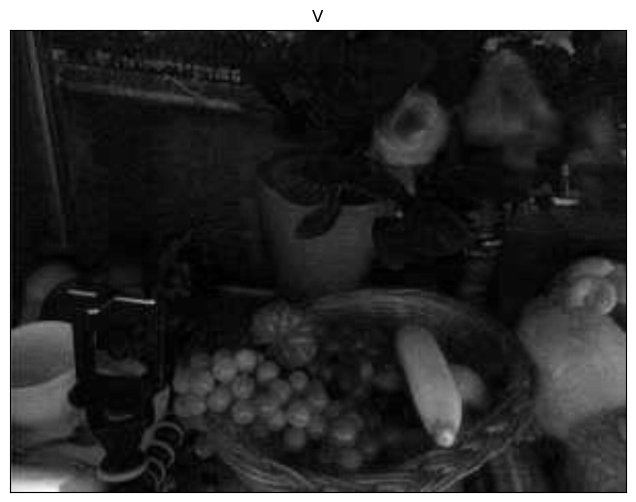

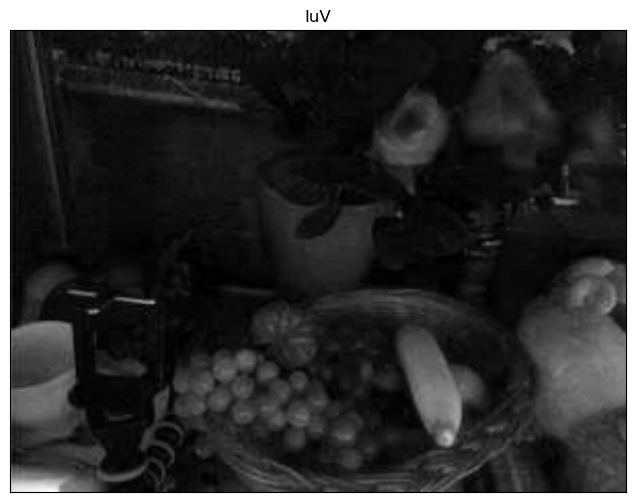

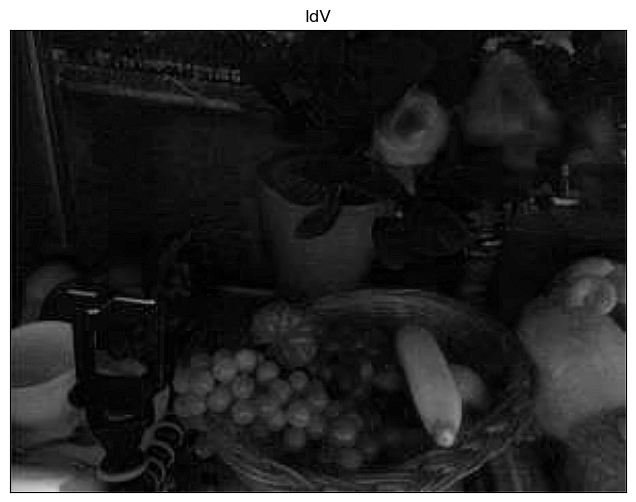

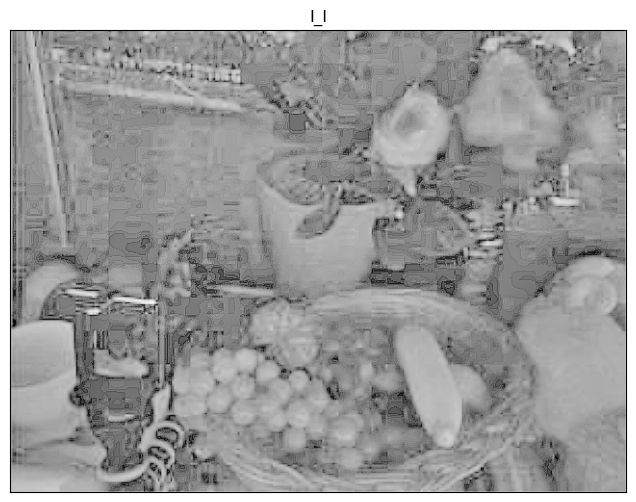

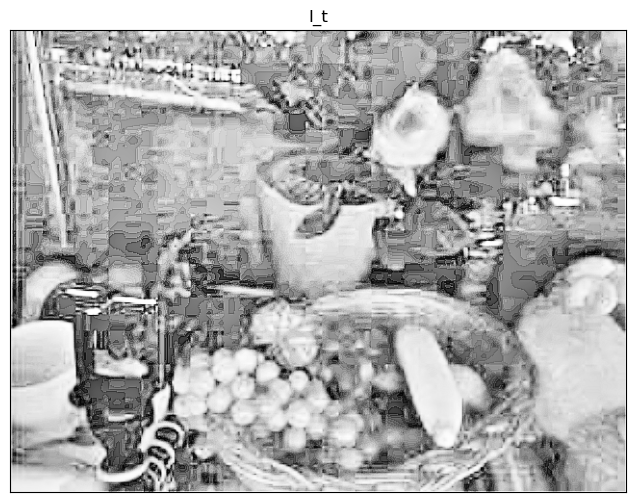

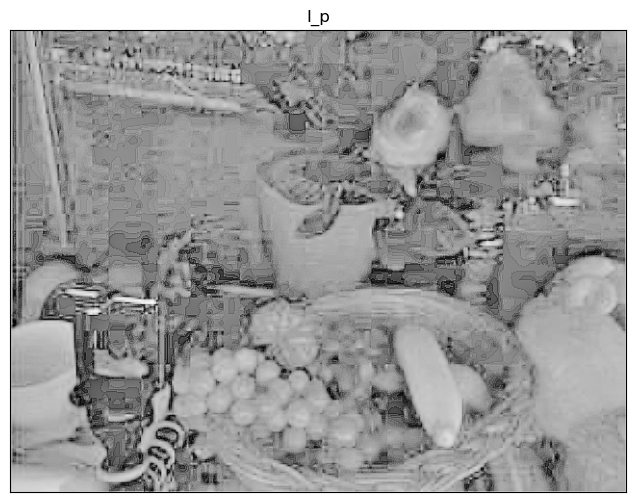

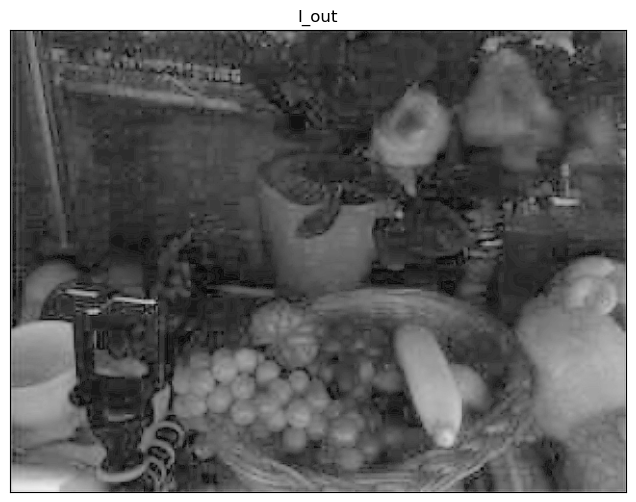

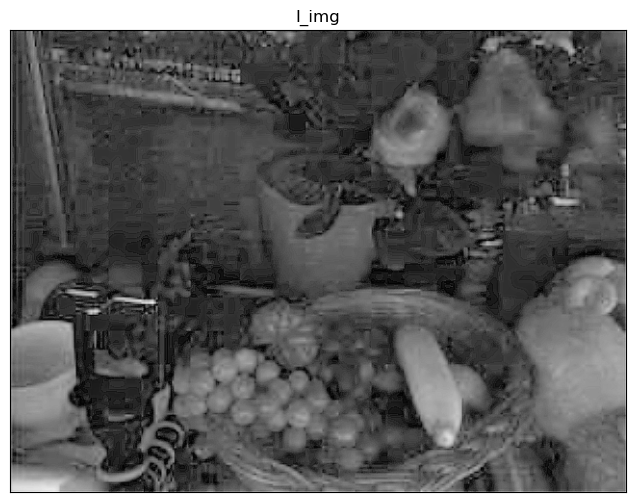

In [153]:
I_u_V= denoise_tv(v, weight=1/90, eps=1e-6, max_num_iter=100)
img_plot(v,'V')
img_plot(I_u_V,'IuV')
I_d_V=adaptive_gamma_transform(I_u_V,n=3,m=3)
img_plot(I_d_V,'IdV')
i_l = msr(I_d_V,[10,40,100])
img_plot(i_l,'I_l')
i_t = mtanh(I_d_V,[10,40,100])
img_plot(i_t,'I_t')
I_p = DFIE(I_d_V , sigma=[10,40,400],n =5,m =5)
img_plot(I_p,'I_p')
I_o = three_dim_gamma_correction(I_d_V,n=5,m=5,weights=[0.05,0.05,0.2])
img_plot(I_o,'I_out')
I_img = ((I_o/255.*I_p/255.)*255).astype(np.uint8)
img_plot(I_img,'I_img')


In [122]:
kk=three_dim_gamma_correction(I_d_V,3,3,weights=[0.05,0.05,0.1])

In [40]:
kk

array([[121, 175, 195, ..., 213, 206, 220],
       [140, 178, 197, ..., 189, 187, 204],
       [223, 121, 183, ..., 176, 155, 160],
       ...,
       [102, 101,  96, ...,  94, 107, 115],
       [124, 104, 119, ..., 101, 103, 137],
       [137, 132, 132, ..., 116, 135, 163]], dtype=uint8)

In [26]:
[0.1,0.1,0.15]


[0.1, 0.1, 0.15]

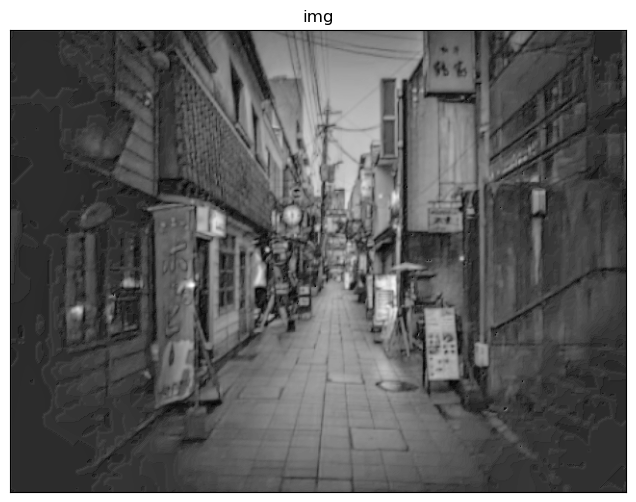

In [123]:
[0.1,0.15,0.05]
img_plot(((kk/255.*I_p/255.)*255))

In [203]:
def adaptive_saturation_adjustment(s_channel):
    """
    Perform adaptive saturation adjustment on the S channel of an image.
    :param s_channel: The S channel of the image, with pixel values between 0 and 1.
    :return: The adjusted S channel, with pixel values between 0 and 1.
    """
    
    # Calculate the mean and standard deviation of the S channel.
    mean_s = np.mean(s_channel)
    std_s = np.std(s_channel)
    
    # Define the minimum and maximum S values.
    min_s = max(mean_s - std_s, 0)
    max_s = min(mean_s + std_s, 1)
    
    # Adjust the S channel using a linear transform to stretch the values to the full range.
    adjusted_s = (s_channel - min_s) / (max_s - min_s)
    
    return adjusted_s.astype(np.uint8)

In [84]:
import cv2
import numpy as np

def remove_dark_spot(saturation, n, m):

    # Apply saturation correction based on local mean and gradient
    mean = cv2.blur(saturation, (n, m))
    gradient = cv2.Sobel(saturation, cv2.CV_64F, 1, 1, ksize=3)
    corrected = saturation - ((saturation - mean) * (gradient / 255.0))
    
    # Set pixels with very low saturation to zero to remove dark spots
    corrected[corrected < 50] = 0
    
    # Merge the corrected saturation channel with the original hue and value channel
    
    return cv2.normalize(corrected, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)


In [75]:
def adaptive_saturation_adjustment(s_channel,n,m):
    s_channel= (s_channel+1.)/255
    rows, cols = s_channel.shape
    saturation_corrected = np.zeros((rows, cols))

    # Get x-gradient in "sx"
    sx = ndimage.sobel(s_channel,axis=-1,mode ='constant')
    # Get y-gradient in "sy"
    sy = ndimage.sobel(s_channel,axis=1,mode ='constant')
    # Get square root of sum of squares

    Sg=np.hypot(sx,sy)
    
    
    # # Compute the global mean value of the S channel
    S_mean = np.mean(s_channel)


    padded_image = cv2.copyMakeBorder(s_channel, n//2, n//2, m//2, m//2, cv2.BORDER_CONSTANT, value=0)
    for i in range(rows):
        for j in range(cols):
            local_region = padded_image[i:i+n, j:j+m]

            # Calculate the average and variance of the local area.
            Sm = np.mean(local_region)

            # Apply regulation
            if s_channel[i,j] <= S_mean+Sg[i,j]:
                saturation_corrected[i,j] = 1+0.8*np.log10(Sm/(s_channel[i,j]+0.5*Sg[i,j]))   
            else:
                saturation_corrected[i,j] = np.exp((Sm-s_channel[i,j])/2)
    # n=m
    # S_mean = np.mean(s_channel)
    # Sm = cv2.blur(s_channel, (m, n))
    # gx = cv2.Sobel(s_channel, cv2.CV_32F, 1, 0, ksize=3)
    # gy = cv2.Sobel(s_channel, cv2.CV_32F, 0, 1, ksize=3)
    # Sg= np.hypot(gx,gy)
    # for i in range(rows):
    #     for j in range(cols):
    #         if s_channel[i,j] <= S_mean+Sg[i,j]:
    #              saturation_corrected[i,j] = 1+0.8*np.log(((Sm[i,j])/(s_channel[i,j]+0.5*Sg[i,j])))   
    #         else:
    #              saturation_corrected[i,j] = np.exp((Sm[i,j]-s_channel[i,j])/2)     
          
    # # print(np.max(Sg-Sg_1))
    return  cv2.normalize(saturation_corrected, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

In [103]:
S_tag.max()

1.0

In [109]:
S_tag


array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

10 0.25


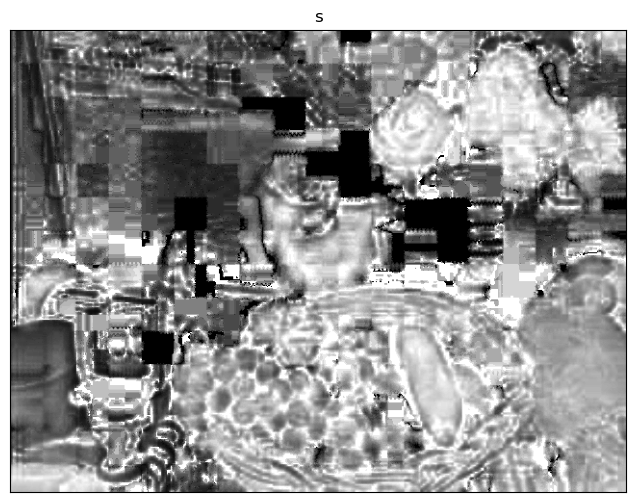

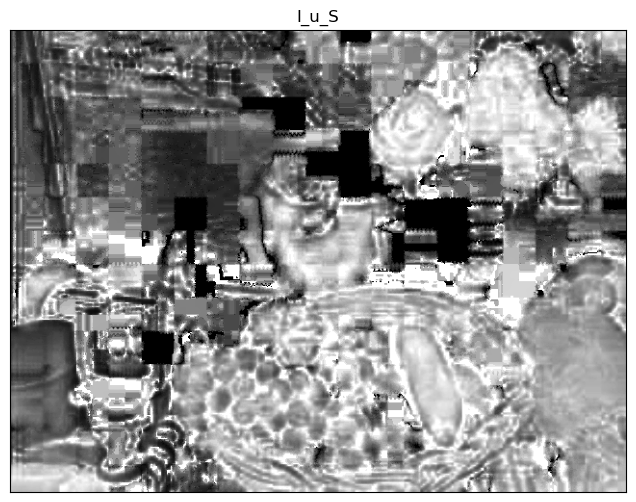

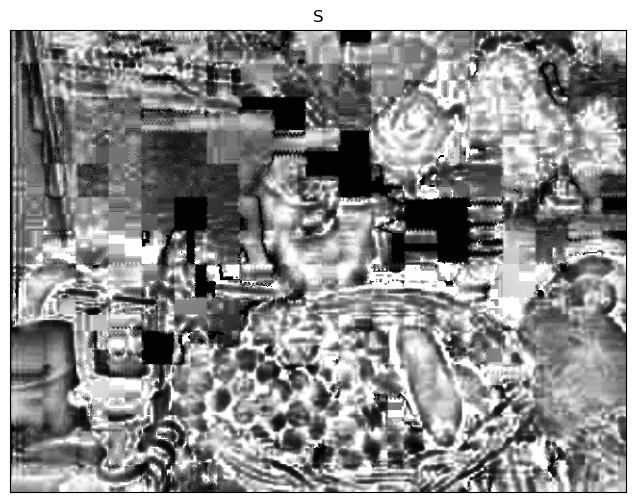

In [154]:
I_u_S= denoise_tv(s, weight=1/100, eps=1e-6, max_num_iter=100)
img_plot(s,'s')
img_plot(I_u_S,'I_u_S')
S_tag = skimage.exposure.equalize_adapthist(I_u_S/255.)
S_tag = cv2.normalize(S_tag, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
img_plot(S_tag,'S')

In [22]:
cv2.imshow('f', (i_l-v))
cv2.setMouseCallback('f', mouse_callback)  
cv2.waitKey(0)
cv2.destroyAllWindows()

In [96]:
cv2.imshow('f',np.concatenate([HSVtoBGR(h,s,i_t),HSVtoBGR(h,s,i_l),HSVtoBGR(h,s,I_p)],axis=1))
cv2.setMouseCallback('f', mouse_callback)  
cv2.waitKey(0)
cv2.destroyAllWindows()

In [157]:

cv2.imshow('f', np.concatenate([HSVtoBGR(h,S_tag,I_img),HSVtoBGR(h,I_u_S,I_img),Img],axis=1))
cv2.setMouseCallback('f', mouse_callback)  
cv2.waitKey(0)
cv2.destroyAllWindows()


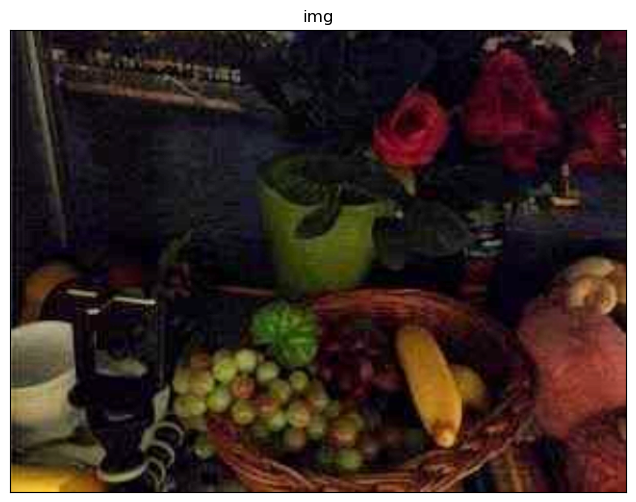

In [155]:

import skimage
I = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
eq = skimage.exposure.equalize_adapthist(I)
img_plot(eq)

c:\Users\rusla\anaconda3\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


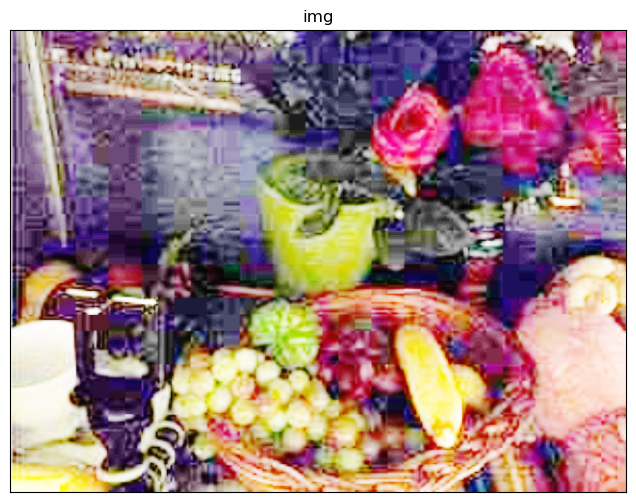

In [156]:

dst = skimage.exposure.equalize_hist(I)
img_plot(dst)
